In [4]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import statistics
# MAY NOT NEED THE BELOW
from numpy import random, nanmax, argmax, unravel_index
from scipy.spatial.distance import pdist, squareform

Text(0.5, 1.0, 'Blurred Cropped Image')

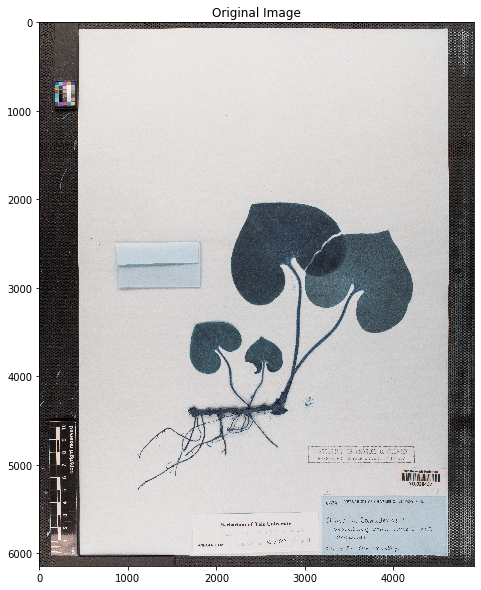

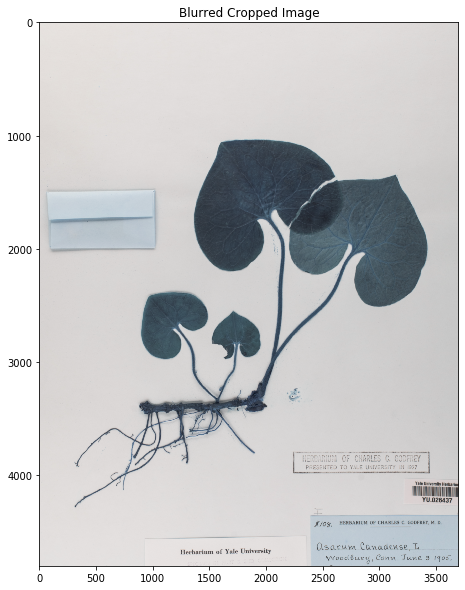

In [5]:
img = cv2.imread('leaf-ex-2.jpg')
fig = plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title("Original Image")

# NOTE: [y, x]
img = img[1000:5800, 800:4500]
blur = cv2.GaussianBlur(img, (21, 21), 2)
h, w = img.shape[:2]

fig = plt.figure(figsize=(10,10))
plt.imshow(blur)
plt.title("Blurred Cropped Image")

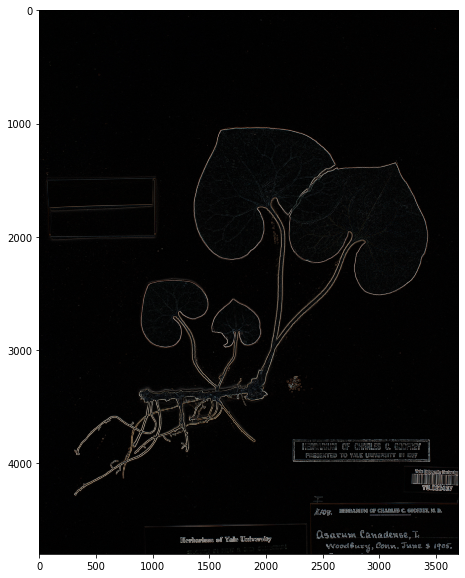

In [6]:
# Morphological gradient
# 1st: Ellipse shaped to put where 1's are 
# 2nd: kernel size
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))

# MORPH_GRADIENT = difference between erosion and dilation
# Will provide the outline of the leaves
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)

fig = plt.figure(figsize=(10,10))
plt.imshow(gradient)

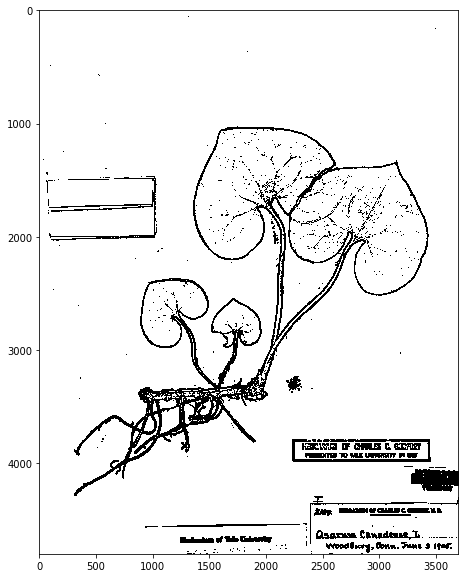

In [7]:
# Binarize gradient
lowerb = np.array([0, 0, 0])
uval = 15
upperb = np.array([uval, uval, uval])

# ?? Creates the mask to threshold for what is edges 
# inRange: Thresholds to get certain colors -> in this case, thresholding to 
#     find edges
binary = cv2.inRange(gradient, lowerb, upperb)

fig = plt.figure(figsize=(10,10))
plt.imshow(binary, cmap='gray')

In [8]:
# NEW CODE
#contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#binary = cv2.drawContours(binary, contours, -1, (0, 255, 0), 3) 
#plt.imshow(binary)

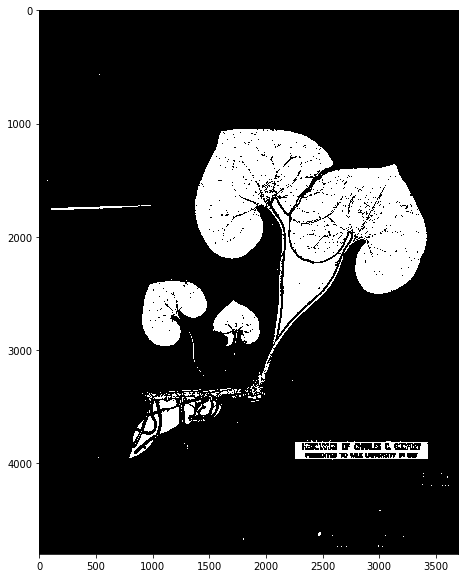

In [9]:
# Flood fill from the edges to remove edge crystals 
# From my understanding, the code below removes edges where we aren't sure 
#      where it ends (i.e. things at the edge of the image)
# Not sure if we will need this since we don't have any leaves at the edges of 
#      an image

for row in range(h):
    if binary[row, 0] == 255:
        cv2.floodFill(binary, None, (0, row), 0)
    if binary[row, w-1] == 255:
        cv2.floodFill(binary, None, (w-1, row), 0)
        
for col in range(w):
    if binary[0, col] == 255:
        cv2.floodFill(binary, None, (col, 0), 0)
    if binary[h-1, col] == 255:
        cv2.floodFill(binary, None, (col, h-1), 0)

fig = plt.figure(figsize=(10,10))
plt.imshow(binary, cmap='gray')

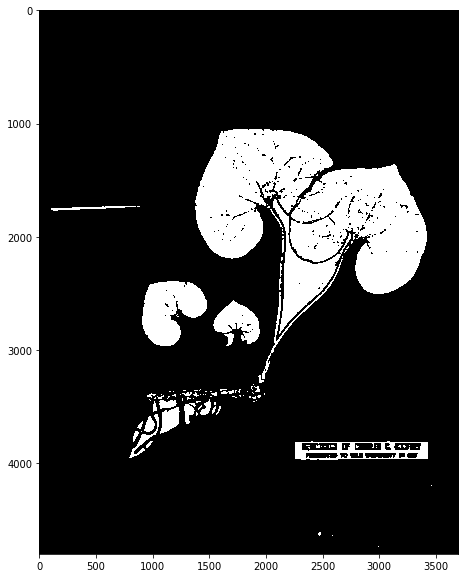

In [10]:
# Cleaning up mask

# Erosion: erodes away the boundaries of foreground object 
# Thickness of the foreground decreases -> less white

# Dilation: increases white region in the image; size of foreground object 
# increases

# Open: Erosion followed by Dilation; good to remove noise outside of image
foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Close: Dilation followed by Erosion; good to remove small holes inside of image
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

# Cleans up foreground
fig = plt.figure(figsize=(10,10))
plt.imshow(foreground, cmap = 'gray')

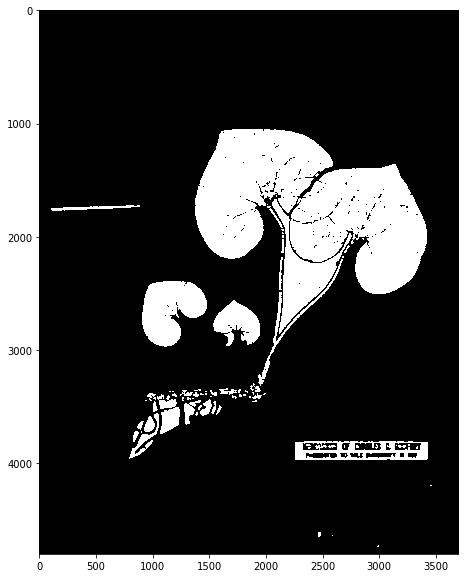

In [11]:
# Creating background and unknown mask for labeling

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
background = cv2.dilate(foreground, kernel, iterations=3)
unknown = cv2.subtract(background, foreground)

fig = plt.figure(figsize=(10,10))

plt.imshow(background, cmap = 'gray')

In [12]:
# Watershed

# Computes the connected components labeled image of boolean image 
# Outputs total number of labels; 0 = background
markers = cv2.connectedComponents(foreground)[1]
markers += 1  # Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0  # mark the region of unknown with zero
markers = cv2.watershed(img, markers)

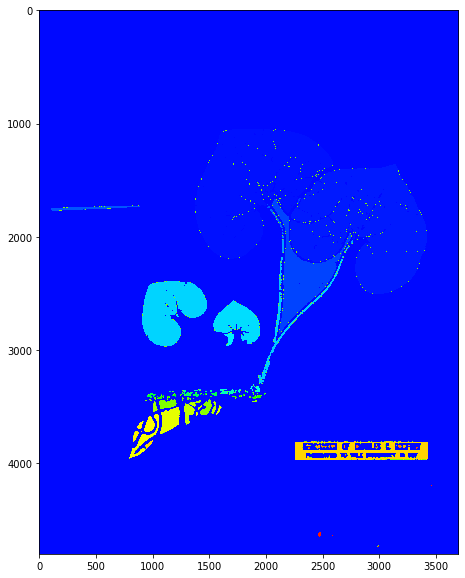

In [13]:
# Assign the markers a hue between 0 and hue_max
hue_max = 120
hue_markers = np.uint8(hue_max*np.float32(markers)/np.max(markers))

blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)

fig = plt.figure(figsize=(10,10))
plt.imshow(marker_img)

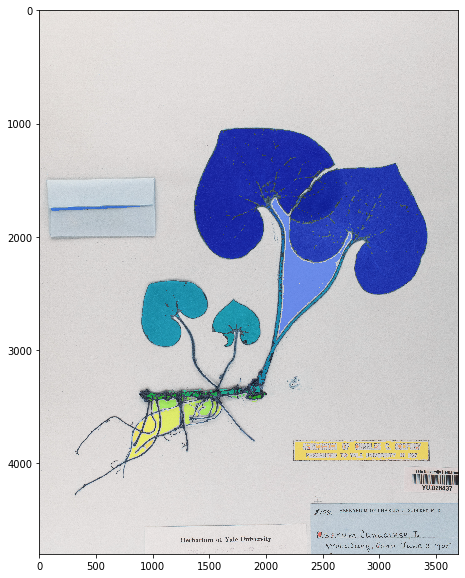

In [14]:
# Label the original image with the watershed markers

labeled_img = img.copy()
labeled_img[markers>1] = marker_img[markers>1]  # 1 is background color
labeled_img = cv2.addWeighted(img, 0.5, labeled_img, 0.5, 0)

fig = plt.figure(figsize=(10,10))
plt.imshow(labeled_img)

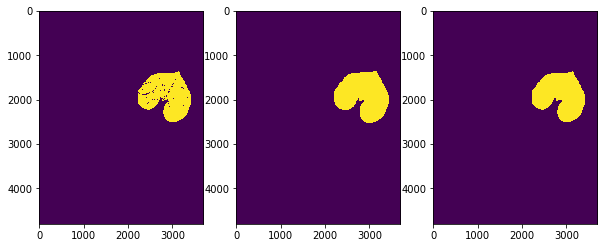

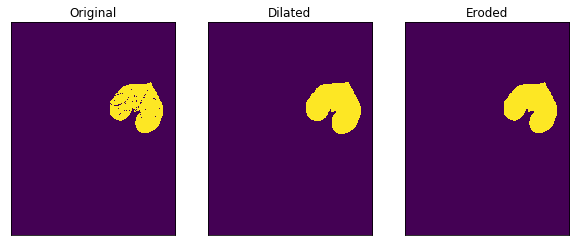

In [15]:
img2 = img.copy()

# Find markers corresponding to a particular watershed
markers1 = ((markers == 3)).astype(np.uint8) 
ret, m2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8) 
dm2 = cv2.dilate(m2, kernel, iterations=6)
lf4_em2 = cv2.erode(dm2, kernel, iterations=6)
fig = plt.figure(figsize=(10,10))

ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)
ax0.imshow(m2)
ax1.imshow(dm2)
ax2.imshow(lf4_em2)

titles = ['Original', 'Dilated', 'Eroded']
all = [m2, dm2, lf4_em2]

fig = plt.figure(figsize=(10,10))
for i in range(3):
    fig.add_subplot(1,3,i+1), plt.imshow(all[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

In [16]:
unq, ct = np.unique(markers, return_counts = True)

# Determine the avg number time a marker is shown
avg = sum(ct) / len(ct) # = 154,434
val = ct > 5000

# Explore these values 
opt = unq[val]
opt

array([-1,  1,  2,  3,  8, 10, 23, 24, 25, 27, 71, 72, 79, 82, 84, 85, 90],
      dtype=int32)

In [17]:
len(unq)

115

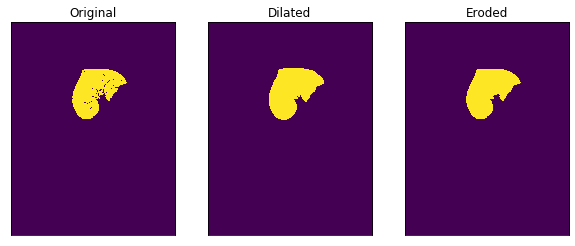

In [18]:
# TRIED: 1, 2, 3, 8, 10, 23, 24, 25, 27, 71, 72, 79, 82, 84, 85, 90
# stems = 23
# leaves = 3, 24, 25
markers1 = ((markers == 2)).astype(np.uint8) 

# NOTE: can see functions by doing help([function_name])

# Threshold = if a pixel value is greater than threshold => assign to one value (white)
#     if not, assign to another value (black)
#     Arugments: (1) source image (grayscale), (2) threshold value to classify pixel value
#       (3) maxVal = value to be given if pixel is more than the threshold val
# Otsu = calculates the threshold value from an image hisogram that has 2 peaks
# ret = returns the optimal threshold value 
ret, m2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8) 
dm2 = cv2.dilate(m2, kernel, iterations=6)
lf3_em2 = cv2.erode(dm2, kernel, iterations=6)

titles = ['Original', 'Dilated', 'Eroded']
all = [m2, dm2, lf3_em2]

fig = plt.figure(figsize=(10,10))
for i in range(3):
    fig.add_subplot(1,3,i+1), plt.imshow(all[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

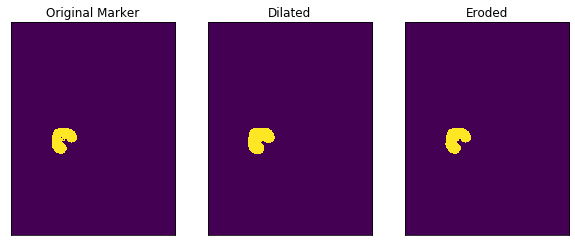

In [19]:
markers1 = ((markers == 24)).astype(np.uint8) 

ret, m2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8) 
dm2 = cv2.dilate(m2, kernel, iterations=6)
lf1_em2 = cv2.erode(dm2, kernel, iterations=6)

titles = ['Original Marker', 'Dilated', 'Eroded']
all = [m2, dm2, lf1_em2]

fig = plt.figure(figsize=(10,10))
for i in range(3):
    fig.add_subplot(1,3,i+1), plt.imshow(all[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

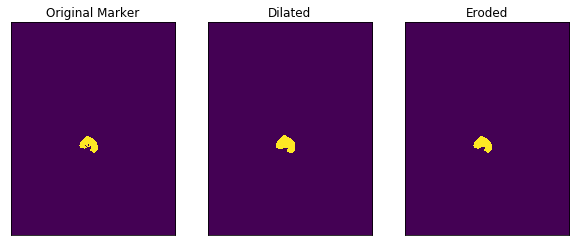

In [20]:
markers1 = ((markers == 25)).astype(np.uint8) 

ret, m2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8) 
dm2 = cv2.dilate(m2, kernel, iterations=6)
lf2_em2 = cv2.erode(dm2, kernel, iterations=6)

titles = ['Original Marker', 'Dilated', 'Eroded']
all = [m2, dm2, lf2_em2]

fig = plt.figure(figsize=(10,10))
for i in range(3):
    fig.add_subplot(1,3,i+1), plt.imshow(all[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

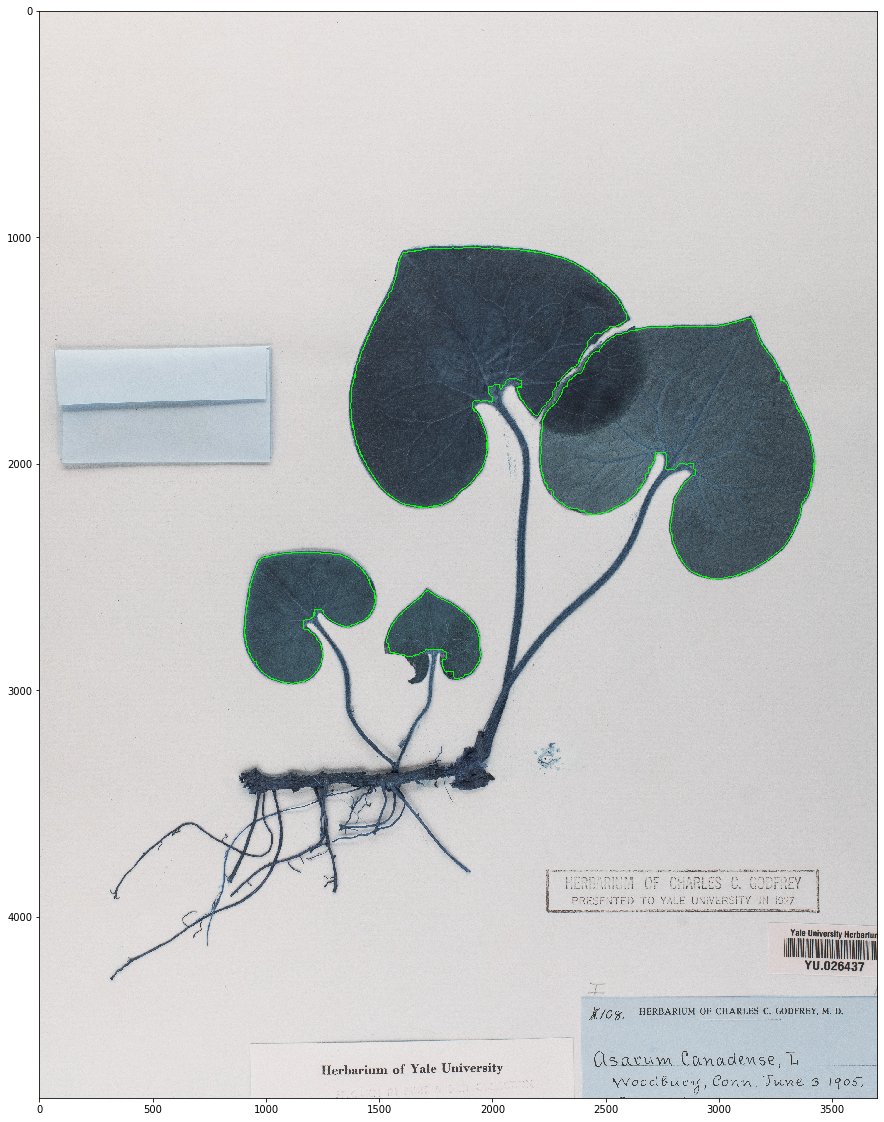

In [21]:
contours, hierarchy = cv2.findContours(lf4_em2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# access the array and then -1 implies to draw all the contours indicated by c
for c in contours:
    cv2.drawContours(img2, c, -1, (0, 255, 0), 3)

contours2, hierarchy = cv2.findContours(lf3_em2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for c in contours2:
    cv2.drawContours(img2, c, -1, (0, 255, 0), 3)

contours3, hierarchy = cv2.findContours(lf2_em2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for c in contours3:
    cv2.drawContours(img2, c, -1, (0, 255, 0), 3)

contours4, hierarchy = cv2.findContours(lf1_em2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for c in contours4:
    cv2.drawContours(img2, c, -1, (0, 255, 0), 3)
    
fig = plt.figure(figsize=(20,20))
plt.imshow(img2)

In [22]:
# inputs for SVM: (1) perimeter, (2) diameter, (3) contour / convex hull

In [23]:
# (1) PERIMETER 
# Calculates the perimeter of a contour
perimeter = cv2.arcLength(contours[0], True)
print(perimeter)

4804.57810485363


In [24]:
# (2) AREA
area = cv2.contourArea(contours[0])
print(area)

917232.5


In [25]:
# (2) DIAMETER

#print(contours[0][0][0][0])
#print(contours[0][0][0][1])
#print(contours[0][1][0])

temp = contours[0]

#D = pdist(temp)
#D = squareform(D);
#N, [I_row, I_col] = nanmax(D), unravel_index( argmax(D), D.shape )

from itertools import combinations
from random import randint
import math 

def square_distance(x,y): return math.sqrt(sum([(xi-yi)**2 for xi, yi in zip(x,y)]))
#print(square_distance(contours[0][1][0], contours[0][2][0]))

diameter = 0
max_square_distance = 0
max_pair = tuple()
# Combinations returns tuples of n tuples at a time
for pair in combinations(contours[0],2):
    distance = square_distance(pair[0][0], pair[1][0])
    if distance > diameter:
        diameter = distance
        max_pair = pair
        
print(diameter)
print(max_pair)

# broadcasting -> vectorized 
# turn the tuple into array
# fastest way with numpy 

1218.780127832744
(array([[2220, 1808]], dtype=int32), array([[3400, 2113]], dtype=int32))


In [26]:
# (3) AREA / CONVEX HULL

# Convex hull = checks a curve for convexity defects and corrects it
# hull = cv2.convexHull(points[, hull[, clockwise[, returnPoints]]
# points = are the contours we pass into.
# hull is the output, normally we avoid it.
# clockwise: Orientation flag. If it is True, the output convex hull is oriented clockwise. 
#            Otherwise, it is oriented counter-clockwise.
# returnPoints: By default, True. Then it returns the coordinates of the hull points. 
#               If False, it returns the indices of contour points corresponding to the hull points.

# Why this: 
for c in contours:
    hull = cv2.convexHull(c)

# VS
hull = cv2.convexHull(contours[0])

hull_area = cv2.contourArea(hull)
solidity = float(area)/hull_area
print(solidity)

0.8956224731564447


In [27]:
# SVM
from sklearn import svm

#an array X of size [n_samples, n_features] holding the training samples
#an array y of class labels (strings or integers), size [n_samples]

# (1) classify the leaves first: contours for the leaves 
# (2) per contour basis -> 
# 3 inputs scaled down to 2D -> lobed v nonlobed 

#perimeter = [perimeter leaf 1, ]
X = [["leaf1 in image 1", "leaf_image2.jpg", "leaf_image3.jpg"], [perimeter, diameter, solidity]]
X = [[per1, dia1, sold1], [per1, dia1, sold1], [per1, dia1, sold1]]
y = ["lobed", "non-lobed", "lobed"]
# whether it works or not -> probably play with the perimeters 
# OR y = [1, 0, 1]

# svm.SVC: how do we determine what kind of kernel size we want to use?  
#         C is a valuation of "how badly" you want to properly classify, or fit, everything
clf = svm.SVC()
clf.fit(X, y)

# We can then use the results to predict a pair of points after we use SVM

NameError: name 'per1' is not defined

In [ ]:
# To visualize the data
w = clf.coef_[0]
print(w)

a = -w[0] / w[1]

xx = np.linspace(0,12)
yy = a * xx - clf.intercept_[0] / w[1]

h0 = plt.plot(xx, yy, 'k-', label="non weighted div")

plt.scatter(X[:, 0], X[:, 1], c = y)
plt.legend()
plt.show()